In [11]:
# 부족한 피쳐를 조합, 생성하여 모델 성능 향상

# 특성공학 : 피쳐 추출/선택/생성
# 비선형의 데이터에 대한 피쳐 생성 => 곡선형태의 회귀선 수식
# sklearn.preprocessing내에 포함 
# 데이터 : fish.csv 
# 피쳐 : Perch의 Height, Length, Width
# 타켓 : Perch의 Weight
# 학습유형 : 지도학습 

In [12]:
from sklearn.preprocessing import PolynomialFeatures
# #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures

# poly=PolynomialFeatures(include_bias=False, degree=5)
# poly.fit([[2,3]])
# poly.transform([[2,3]])
# poly.get_features_names_out()

In [13]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform([[2,3,4]])
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [14]:
 '1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'       # interaction_only=False : 자기 자신의 제곱도 함
 '1', 'x0', 'x1', 'x0 x1'                       # interaction_only=True : ㄴㄴ 그냥 서로 꺼만 곱하고 치움
 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'            # interaction_only=False, include_bias=False : 1 빼버리기 

('x0', 'x1', 'x0^2', 'x0 x1', 'x1^2')

In [15]:
import pandas as pd
df=pd.read_csv("../data/fish.csv")
df.drop('Diagonal',axis='columns',inplace=True)

In [16]:
df=df[df["Species"]=="Perch"].reset_index(drop=True)

In [17]:
# 학습 유형 결정을 위한 단계, 피쳐 스케일링 진행 여부 체크 
poly = PolynomialFeatures(degree=2, include_bias=False)
# str=['Weight','Length', 'Height' ,'Width' ,'Weight^2' ,'Weight_Length',
#  'Weight_Height', 'Weight_Width', 'Length^2' ,'Length_Height' ,'Length_Width',
#  'Height^2' ,'Height_Width', 'Width^2']
df2=pd.DataFrame(poly.fit_transform(df[df.columns[2:]]), columns=poly.get_feature_names_out())
#print(poly.get_feature_names_out())
import statsmodels.formula.api as smf # ols 분석 시행하여 유의미한 변수를 찾음


# result = '+'.join(str[1:])
# print(result)
# formula = f'Weight ~ Length+Height+Width+Weight^2+Weight_Length'
# result = smf.ols(formula, df2).fit()
# result.summary()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
result= pd.concat([df[["Weight"]],df2],axis=1) 

In [19]:
df[df.columns[1:]].corr()["Weight"] # Length Height, Length Width, Height Width => 3개로 추림

Weight    1.000000
Length    0.958656
Height    0.968441
Width     0.963943
Name: Weight, dtype: float64

In [20]:
from sklearn.linear_model import LinearRegression

target=df["Weight"]
feature=df[["Length","Width","Height"]]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(feature, 
                                                    target, 
                                                    test_size=0.3)

In [22]:
std_scaler=StandardScaler()
mm_scaler=MinMaxScaler()
rb_scaler=RobustScaler()
sl=[std_scaler, mm_scaler, rb_scaler]

sv= [[],[],[]]
sv2=[[],[],[]]

for i,v in enumerate(sl) :
    v.fit(x_train)
    sv[i]=v.transform(x_train).copy()
    v.fit(x_test)
    sv2[i]=v.transform(x_test).copy()
    
    
x_train_std=sv[0]
x_train_mm=sv[1]
x_train_rb=sv[2]
x_test_std=sv2[0]
x_test_mm=sv2[1]
x_test_rb=sv2[2]

In [23]:

dataset=[x_train_std, x_train_mm, x_train_rb, x_test_std, x_test_mm, x_test_rb]
score_list=[]
for i in range(int(len(dataset)/2)) :
    model=LinearRegression()
    model.fit(dataset[i], y_train)
    train_score=model.score(dataset[i], y_train)
    model.fit(dataset[i+3], y_test)
    test_score=model.score(dataset[i+3], y_test)
    score_list.append([train_score, test_score])


In [24]:
score_list

[[0.9387531408167363, 0.9580537823980138],
 [0.9387531408167364, 0.9580537823980138],
 [0.9387531408167364, 0.9580537823980138]]

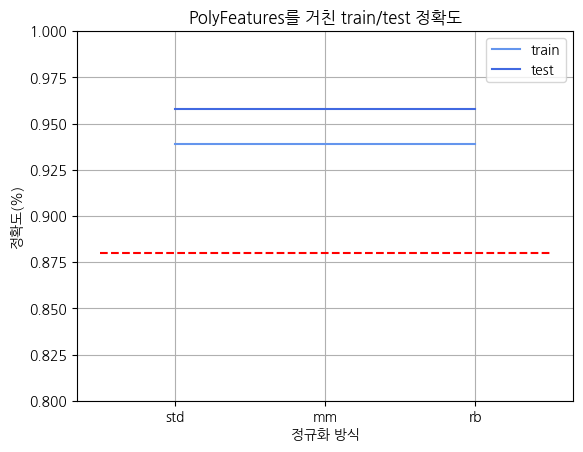

In [25]:
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
data=np.array(score_list).T
plt.plot(range(3), data[0], color='cornflowerblue', label='train')
plt.plot(range(3), data[1], color='royalblue', label='test')
plt.legend()
plt.hlines(y=0.88, xmin=-0.5, xmax=2.5, colors='r', linestyles='dashed', label='Horizontal Line')
plt.xticks(range(3), ['std', 'mm', 'rb'])
plt.xlabel("정규화 방식")
plt.ylabel("정확도(%)")
plt.title("PolyFeatures를 거친 train/test 정확도")
plt.ylim(0.8, 1)
plt.grid(True)
plt.show()